In [1]:
from pypsdm.models.input.container.participants import SystemParticipantsContainer
from pypsdm.models.result.container.participants import ParticipantsResultContainer
from pypsdm.models import gwr
from pypsdm.analysis.concurrency import (calc_glg, curve_regression, do_all_glg_plots, get_installed_capacity)
from datetime import datetime
from pypsdm.processing.series import quarter_hourly_mean_resample
import pandas as pd
import os

# Get the folder path where the files are located
#folder_inputs = r'C:\tmp\20231121_flex_testminigrid_2023-11-21_08-37-58\input\grid'
#folder_res = r'C:\tmp\20231121_flex_testminigrid_2023-11-21_08-37-58\rawOutputData'
#folder_glz_cases = r'C:\tmp\20231121_flex_testminigrid_2023-11-21_08-37-58\input\GLZ'
folder_inputs = r'C:\tmp\20231113_flex_testgrid_2023-12-18_14-06-09\input\grid'
folder_res = r'C:\tmp\20231113_flex_testgrid_2023-12-18_14-06-09\rawOutputData'
folder_glz_cases = r'C:\tmp\20231113_flex_testgrid_2023-12-18_14-06-09\input\GLZ'
# endtime = datetime(2020,1,1)
endtime = datetime(2019, 12, 31)


file_name_glz_cases = 'em_to_case_dict.csv'
em_cases_dict = pd.read_csv(os.path.join(folder_glz_cases, file_name_glz_cases), index_col=0).rename_axis(index='em_uuid')


gwr = gwr.GridWithResults.from_csv('flex_minigrid', folder_inputs,',',folder_res,',', simulation_end=endtime)


In [2]:
from pypsdm.analysis.concurrency import (get_installed_capacity)
df_input = em_cases_dict.index.tolist()
em_installed_capacity_res_2 = get_installed_capacity(df_input,gwr)


In [3]:
from pypsdm.analysis.concurrency import (getCasesFromConditions, getCasesFromConditions2)

# Vorhandene Fälle
# PV immer an
# 1. Spalte: BS
# 2. Spalte: EV
# 3. Spalte: HP vorhanden
# 4. Spalte: neue HP & Dämmung


cases = [
    (1, 1, 1, 1),
    (1, 1, 1, 0),
    (1, 1, 0, 1),
    (1, 1, 0, 0),
    (1, 0, 1, 1),
    (1, 0, 1, 0),
    (1, 0, 0, 1),
    (1, 0, 0, 0),
    (0, 1, 1, 1),
    (0, 1, 1, 0),
    (0, 1, 0, 1),
    (0, 1, 0, 0),
    (0, 0, 1, 1),
    (0, 0, 1, 0),
    (0, 0, 0, 1),
    (0, 0, 0, 0),
]

# Resultierende Fälle für GLZ => Remove wenn 3. Spalte == 1 und Spalte 1 und 2 nicht 1

filtered_cases = [case for case in cases if case[2] != 0 or case[0] == 1 or case[1] == 1]

filtered_cases

# Fälle Binär-codiert (1,1,1,1 ==15)
# Gemeinsame Analyse von 
# Fall 14 und Fall 15 (identisch nur neue oder alte WP & Dämmung) => BS + EV + WP
# 13 und 12 (identisch) => BS + EV
# 11 und 10 (identisch nur neue oder alte WP & Dämmung) BS + WP 
# 9 und 8 (identisch) => Nur BS
# 7 und 6 (identisch nur neue oder alte WP & Dämmung) => EV + WP 
# 4 und 5 (identisch) => Nur EV
# 2 und 3 (identisch nur neue oder alte WP & Dämmung) => Nur WP


#test = getCasesFromConditions(em_cases_dict, 0,0,1,1)
test = em_cases_dict[
                             (em_cases_dict['0'] == 0) 
                             & (em_cases_dict['1'] == 0) 
                             & (em_cases_dict['2'] == 1) 
                             #& (em_cases_dict['3'] == 1)
]


In [4]:
test

,0,1,2,3
em_uuid,,,,
9d135061-438a-4287-ba33-452182a18584,0,0,1,1
fa2a36e7-0422-4689-b89c-bab45162f692,0,0,1,1
7f38941b-9194-48cc-a90a-e9b4aba11235,0,0,1,1
f4a9dd7d-9314-41be-8eba-ec8ddbb8ea74,0,0,1,1
adf16e3f-b9aa-4d5d-9050-cc43309f3157,0,0,1,1
32bd235c-e724-43c4-9e34-b3a138ca5aaf,0,0,1,1
84e47dd3-8c0e-4798-b47b-bfd430ae407d,0,0,1,1
3ef037eb-e442-4d31-8850-4e21ea94902f,0,0,1,0
9ca59182-af6b-408c-a9a2-4145fd07c4b2,0,0,1,0


In [5]:
import uuid

new_df = pd.DataFrame() 
for item in test.index:
    data_for_item = gwr.results.participants.ems[item].p
    new_column_name = item
    new_df[new_column_name] = data_for_item
    

In [6]:
len(new_df.columns)

14

In [7]:
# Parameter, die einzustellen sind:
#num_vehicles = 100
# len_curve = 150  # Ziel: 150, gibt die maximale Anzahl an EV innerhalb der GZ-Kurve an
len_curve = min(len(new_df.columns),150)   # Ziel: 150, gibt die maximale Anzahl an EV innerhalb der GZ-Kurve an
num_mc = 300  # Ziel: 1000, Anzahl an Monte-Carlo-Iterationen pro Punkt in der GZ-Kurve

"""
 Initialisierung
"""

# Initialisierung
#temp_profile = pd.DataFrame(np.zeros(shape=(0, num_vehicles)))
#temp_sim = pd.DataFrame(np.zeros(shape=(num_mc, 1)))

# Einlesen der Daten:

# FIXME: s anstatt P?
df_resample = quarter_hourly_mean_resample(new_df)
# df_resample = df_resample.filter(em_installed_capacity_res.index)
# df_norm = normalize_dataframe_by_installed_capacity(df_resample, em_installed_capacity_res)
# df_norm = normalize_dataframe_min_max(df_resample)
df = df_resample

sim_curve, quantile_95, quantile_95_tot, quantile_95_indices = calc_glg(df,em_installed_capacity_res_2, len_curve, num_mc)


Calculate coincidence factor for system participant number 1
Calculate coincidence factor for system participant number 2
Calculate coincidence factor for system participant number 3
Calculate coincidence factor for system participant number 4
Calculate coincidence factor for system participant number 5
Calculate coincidence factor for system participant number 6
Calculate coincidence factor for system participant number 7
Calculate coincidence factor for system participant number 8
Calculate coincidence factor for system participant number 9
Calculate coincidence factor for system participant number 10
Calculate coincidence factor for system participant number 11
Calculate coincidence factor for system participant number 12
Calculate coincidence factor for system participant number 13
Calculate coincidence factor for system participant number 14


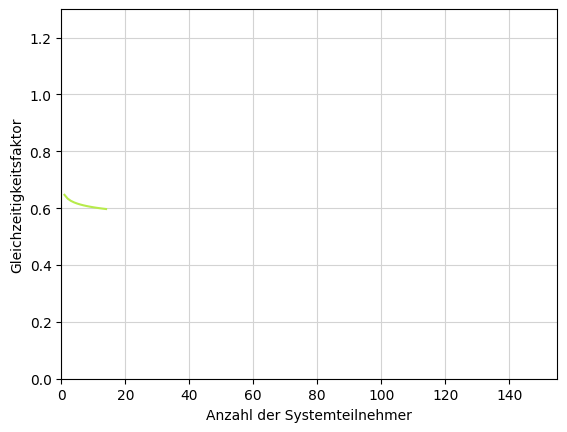

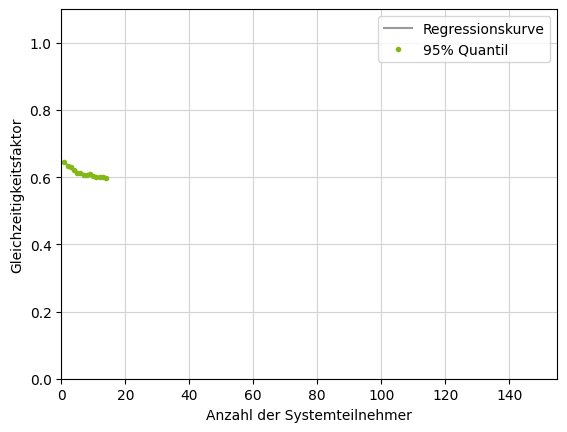

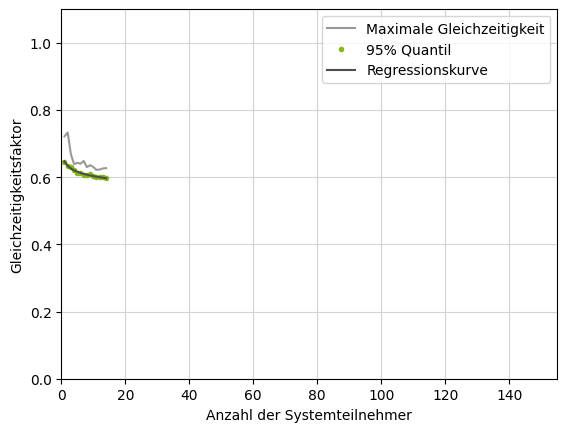

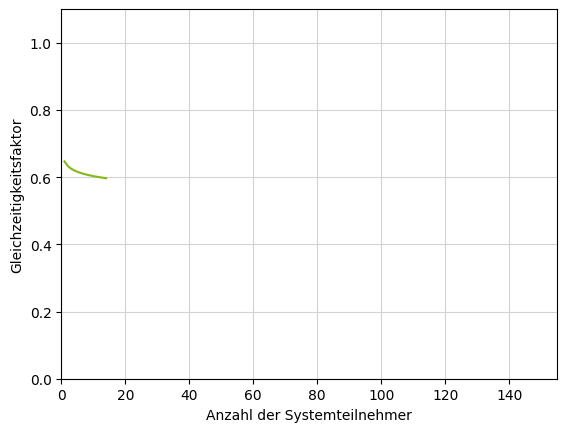

In [8]:
x,y = curve_regression(quantile_95_indices,quantile_95, quantile_95_tot)
do_all_glg_plots(x,y,sim_curve,quantile_95_tot)